In [1]:
# This script pulls in salary data, builds and tests several predictive models,
# and then makes salary predictions on test data using the best model

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    '''perform inner join to return only records that are present in both dataframes'''
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars],drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')



In [3]:
    #define inputs
    train_feature_file = 'train_features.csv'
    train_target_file = 'train_salaries.csv'
    test_feature_file = 'test_features.csv'

    #define variables
    categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
    numeric_vars = ['yearsExperience', 'milesFromMetropolis']
    target_var = 'salary'

    #load data
    print("........Data Loading started ...........")
    feature_df = load_file(train_feature_file)
    target_df = load_file(train_target_file)
    test_df = load_file(test_feature_file)
    print("........Data Loading Ended .............")
    #consolidate training data
    raw_train_df = consolidate_data(feature_df, target_df, key='jobId')

    #clean, shuffle, and reindex training data -- shuffling may improve cross-validation accuracy
    clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

    #encode categorical data and get final feature dfs
    print("Encoding data started.........")
    feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
    test_df = one_hot_encode_feature_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars)
    print("Encoding data completed.......")
    #get target df
    target_df = get_target_df(clean_train_df, target_var)

    

........Data Loading started ...........
........Data Loading Ended .............
Encoding data started.........
Encoding data completed.......


In [4]:
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}
res = {}

    #define number of processes to run in parallel
num_procs = 2

    #shared model paramaters
verbose_lvl = 5

    #create models -- hyperparameter tuning already done by hand for each model
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                               max_features=30, verbose=verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=verbose_lvl)

models.extend([lr, lr_std_pca, rf, gbm])

print(models.extend)
    

<built-in method extend of list object at 0x7fda55c17e00>


In [5]:
models

[LinearRegression(),
 Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                 ('linearregression', LinearRegression())]),
 RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                       n_estimators=60, n_jobs=2, verbose=5),
 GradientBoostingRegressor(max_depth=5, n_estimators=40, verbose=5)]

In [6]:
#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

   


Beginning cross validation

Model:
 LinearRegression()
Average MSE:
 384.45973666371924
Standard deviation during CV:
 0.2577841513914052

Model:
 Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])
Average MSE:
 384.45347064752855
Standard deviation during CV:
 0.24897559501562228

Model:
 RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=60, n_jobs=2, verbose=5)
Average MSE:
 368.42821523440256
Standard deviation during CV:
 0.4369028827705961

Model:
 GradientBoostingRegressor(max_depth=5, n_estimators=40, verbose=5)
Average MSE:
 398.15235202298277
Standard deviation during CV:
 0.9766577235891418


In [7]:
 #choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)




Predictions calculated using model with lowest MSE:
RandomForestRegressor(max_depth=25, max_features=30, min_samples_split=60,
                      n_estimators=60, n_jobs=2, verbose=5)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 60building tree 2 of 60

building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.0min


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tr

[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  4.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   13.6s finished


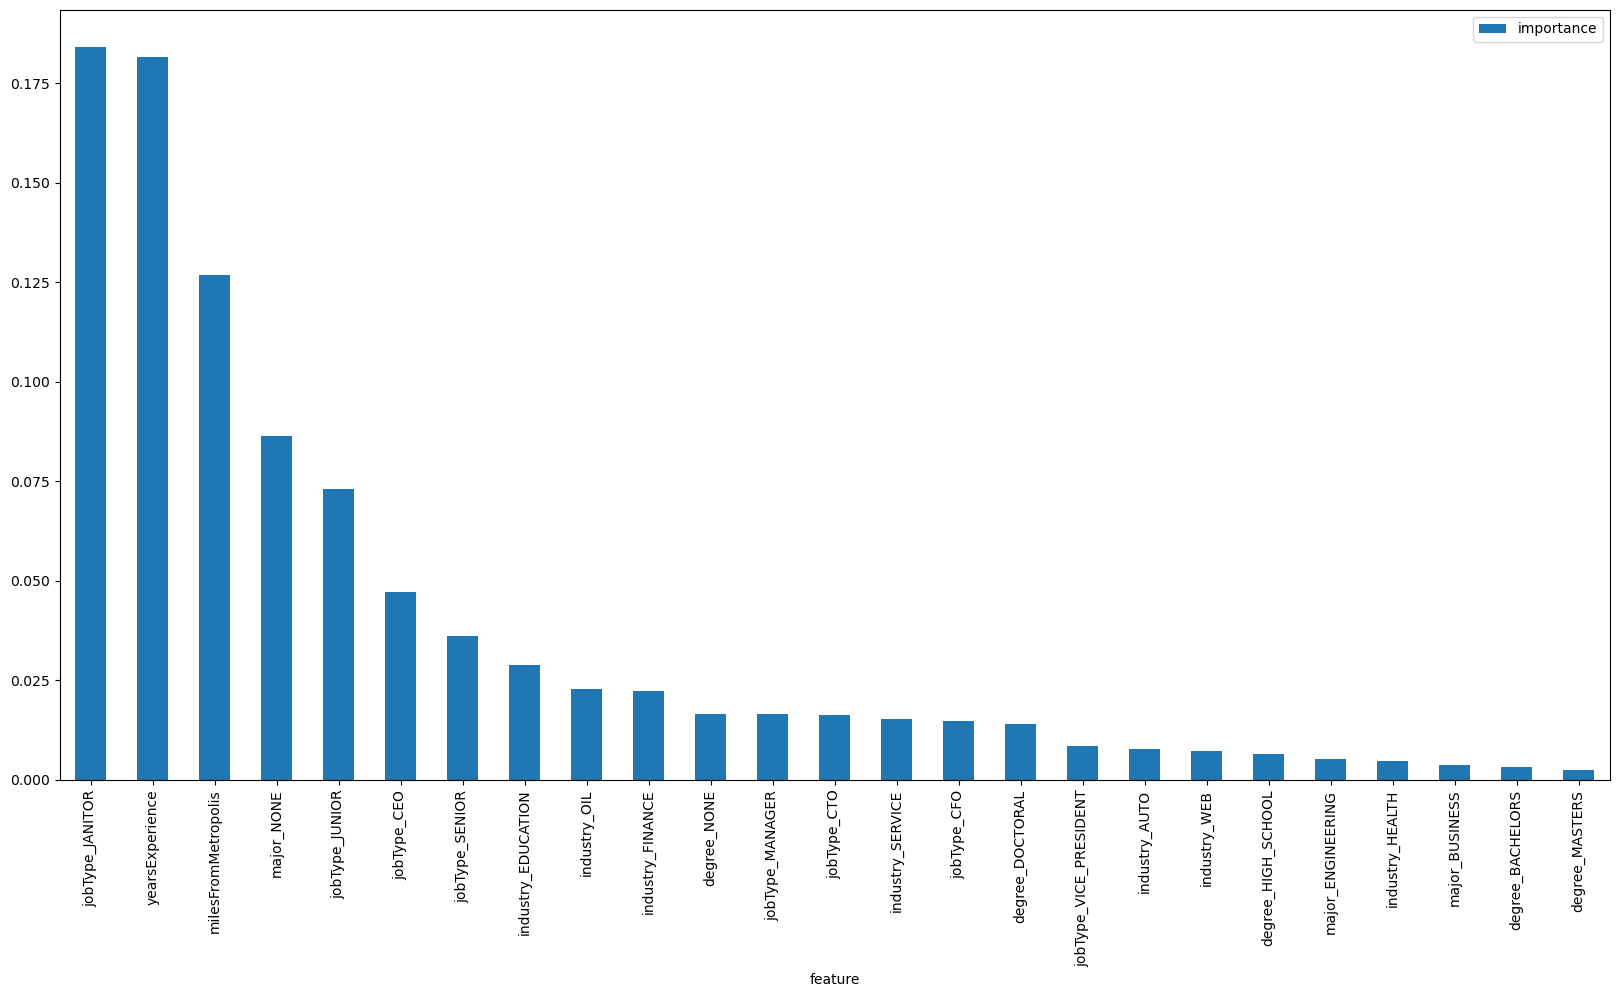

In [8]:
   #train model on entire dataset
model.fit(feature_df, target_df)

    #create predictions based on test data
predictions = model.predict(test_df)

    #store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)

feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
    
#create plot
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

#save results
save_results(model, mean_mse[model], predictions, feature_importances)